In [ ]:
#Nama   : Ardhien Fadhillah Suhartono
#NIM    : 1103204137
#Kelas  : TK44402

In [12]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [13]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [15]:
np.random.seed(0)

In [16]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)



X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

In [17]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [18]:
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

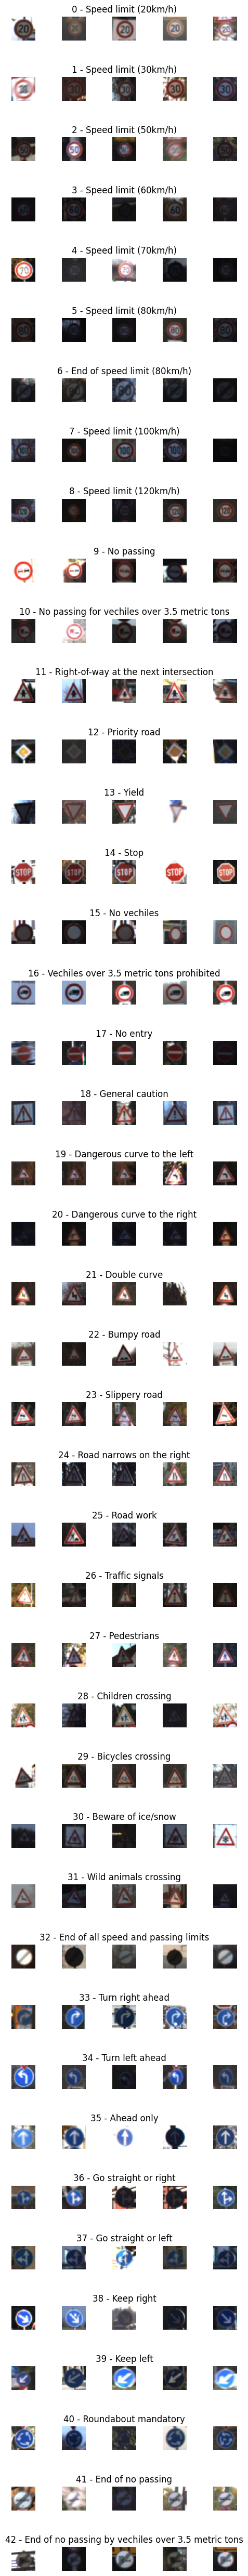

In [19]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


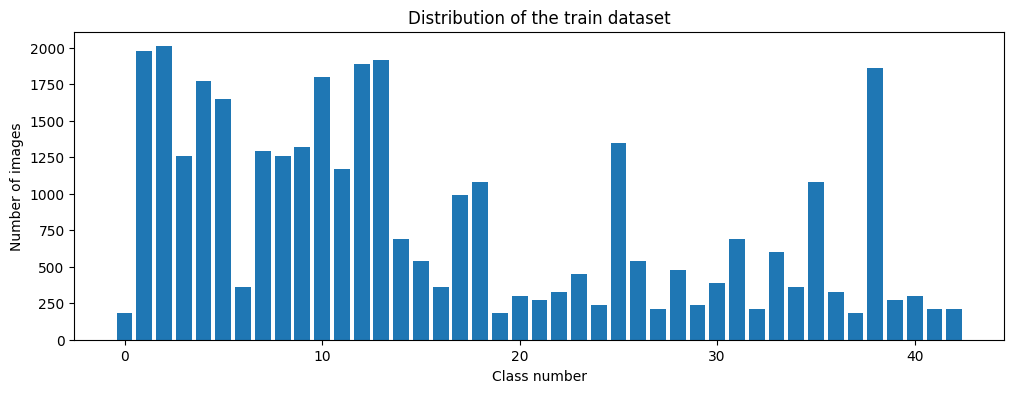

In [20]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
1


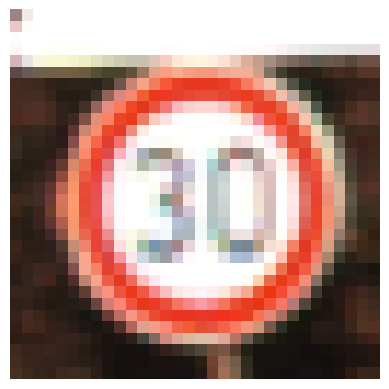

In [21]:
plt.imshow(X_train[3000])
plt.axis("off")
print(X_train[3000].shape)
print(y_train[3000])

(32, 32)


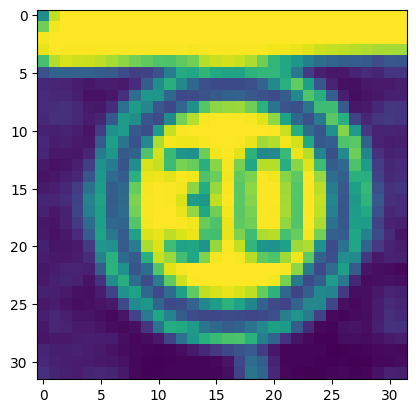

In [22]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[3000])
plt.imshow(img)
#plt.axis("off")
print(img.shape)

(32, 32)


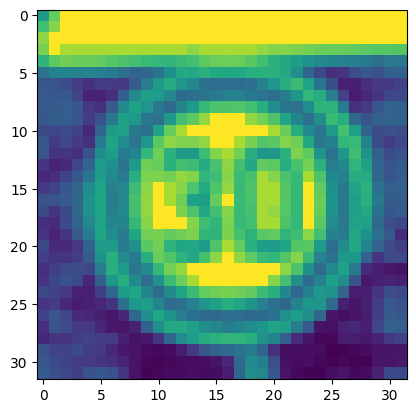

In [23]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
print(img.shape)

In [24]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalize the images, i.e. convert the pixel values to fit btwn 0 and 1
  img = img/255
  return img

In [25]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


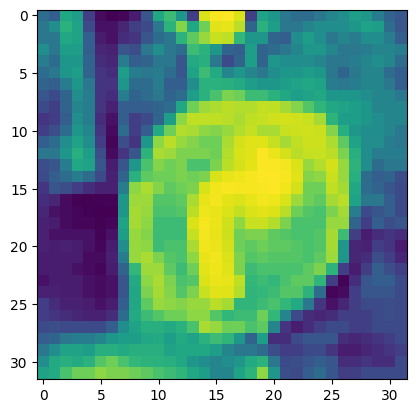

In [26]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

In [27]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [28]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


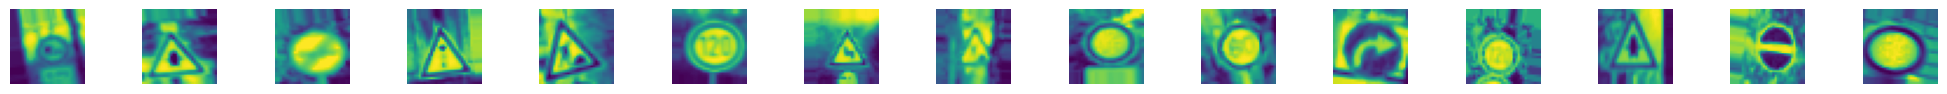

In [29]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [31]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [32]:
def better_model():
  model = Sequential()
  # add the convolutional layer
  #filters, size of filters,input_shape,activation_function
  model.add(Conv2D(60,(5,5), input_shape= (32,32,1), activation = 'relu'))
  model.add(Conv2D(60,(5,5), input_shape= (32,32,1), activation = 'relu'))
  #pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  # add another convolutional layer
  model.add(Conv2D(30, (3, 3) , activation = 'relu'))
  model.add(Conv2D(30, (3, 3) , activation = 'relu'))
  # pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))

  #model.add(Dropout(0.5))

  #Flatten the image to 1 dimensional array
  model.add(Flatten())
  #add a dense layer : amount of nodes, activation
  model.add(Dense(500, activation = 'relu'))
  # place a dropout layer
  #0.5 drop out rate is recommended, half input nodes will be dropped at each update
  model.add(Dropout(0.5))
  # defining the ouput layer of our network
  model.add(Dense(num_classes, activation = 'softmax'))


  #Compile Model
  # we use Adam optimizer with a learning rate 0f 0.01
  # A categorical_crossentropy'

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [33]:
model = better_model()
#print a summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

In [40]:
# Calculate steps_per_epoch based on the size of your training dataset
steps_per_epoch = len(X_train)

# Define your training parameters
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=steps_per_epoch,
                              epochs=15,
                              validation_data=(X_val, y_val),
                              shuffle=1)
history = model.fit(X_train, y_train, batch_size=50, epochs=15, validation_data=(X_val, y_val), shuffle=1)


Epoch 1/15


<ipython-input-40-7e830906423b>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


  696/34799 [..............................] - ETA: 4:43:54 - loss: 0.2379 - accuracy: 0.9258

34799/34799 [==============================] - 368s 11ms/step - loss: 0.2379 - accuracy: 0.9258 - val_loss: 0.1070 - val_accuracy: 0.9735
Epoch 1/15
696/696 [==============================] - 355s 510ms/step - loss: 0.0519 - accuracy: 0.9848 - val_loss: 0.0554 - val_accuracy: 0.9846
Epoch 2/15
696/696 [==============================] - 353s 507ms/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.0607 - val_accuracy: 0.9810
Epoch 3/15
696/696 [==============================] - 356s 511ms/step - loss: 0.0383 - accuracy: 0.9880 - val_loss: 0.0990 - val_accuracy: 0.9771
Epoch 4/15
696/696 [==============================] - 354s 508ms/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.1174 - val_accuracy: 0.9703
Epoch 5/15
696/696 [==============================] - 351s 504ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0660 - val_accuracy: 0.9821
Epoch 6/15
696/696 [==============================] - 351s 503ms/step - loss: 0.0285 - accuracy: 0.9903 - val_loss: 0.1386 - val_acc

Text(0.5, 0, 'epoch')

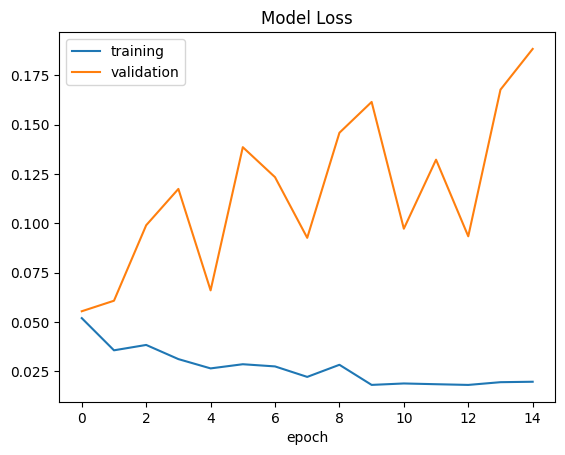

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

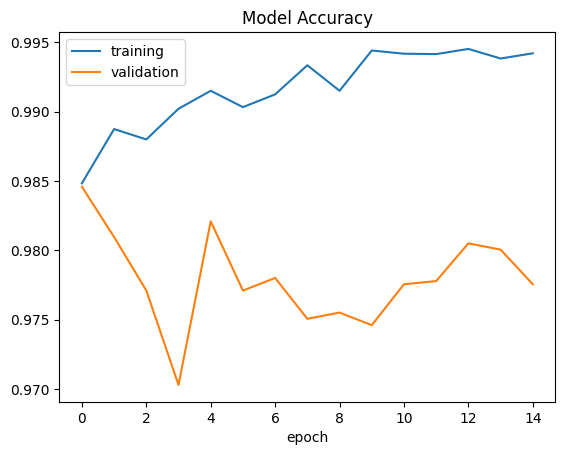

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Model Accuracy')
plt.xlabel('epoch')

In [45]:
score = model.evaluate(X_test, y_test , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.2509581744670868
The Accuracy score is:  0.9570863246917725


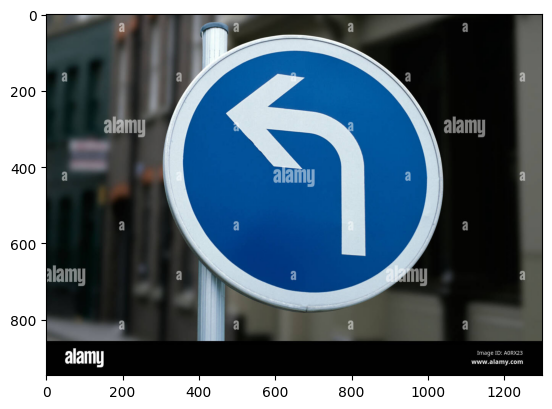

In [48]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


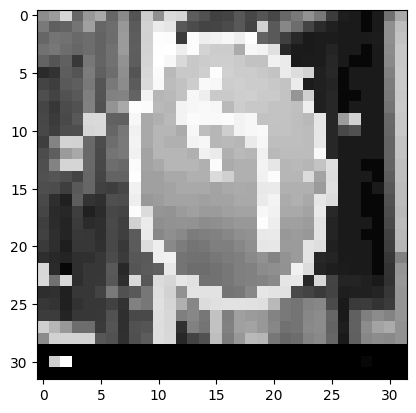

In [49]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [52]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [54]:
#Test image
predicted_probabilities = model.predict(img)
predicted_class = np.argmax(predicted_probabilities)

print("The Predicted class: " + str(predicted_class))

1/1 [==============================] - 0s 258ms/step
The Predicted class: 5


In [55]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model # deletes the existing model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

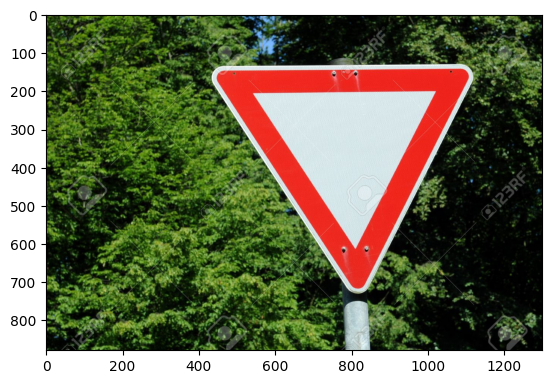

In [57]:
#Testing the Saved Model

#fetch image

import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


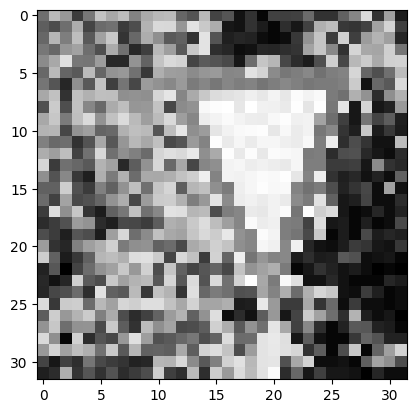

In [58]:

#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [59]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [61]:
#Test image
predicted_probabilities = model.predict(img)
predicted_class = np.argmax(predicted_probabilities)

print("The Predicted class: " + str(predicted_class))

1/1 [==============================] - 0s 173ms/step
The Predicted class: 13
